In [1]:
import pandas as pd
import sys

# Introduction

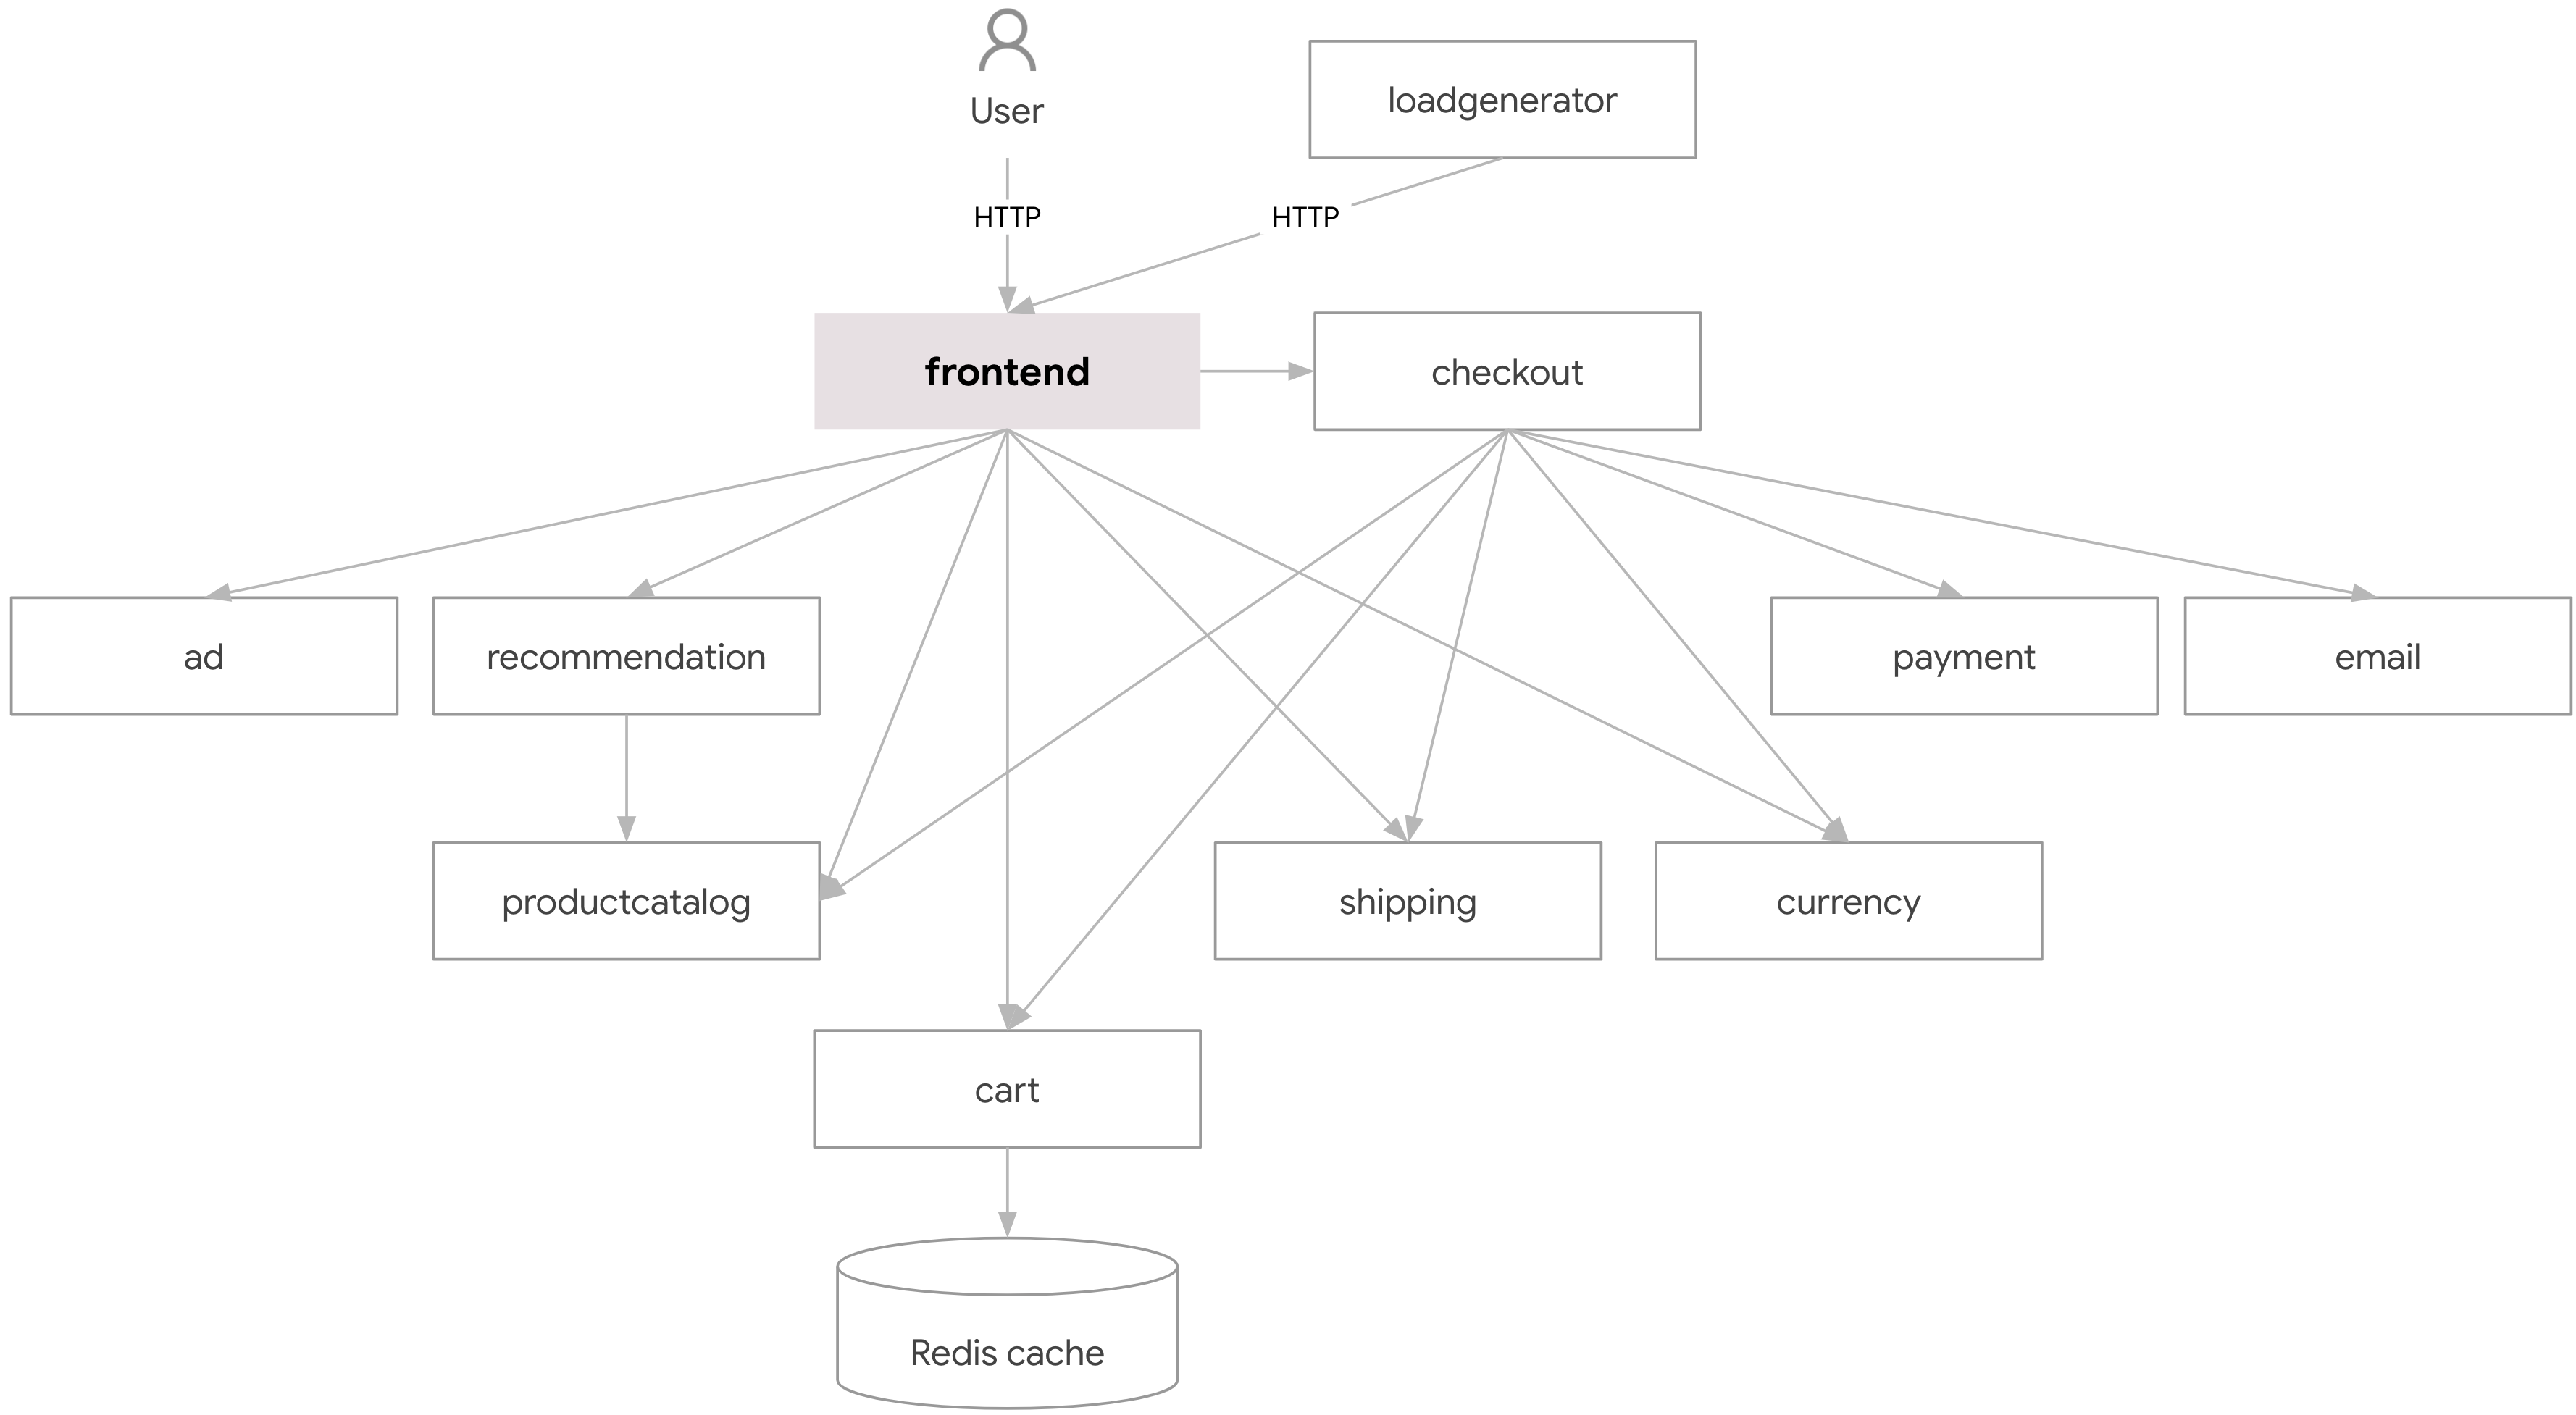

In [1]:
#inline
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Image('https://raw.githubusercontent.com/GoogleCloudPlatform/microservices-demo/main/docs/img/architecture-diagram.png')

# Data set preprocessing

## Load

In [58]:
# Import multiple latency values
p50 = pd.read_csv("Dataset/p50_latency_gcp.csv")
p95 = pd.read_csv("Dataset/p95_latency_gcp.csv")
p99 = pd.read_csv("Dataset/p99_latency_gcp.csv")
gcp_rps = pd.read_csv("Dataset/gcp_rps.csv")

#Concatenate multiple values
df = pd.concat([p50,p95,p99,gcp_rps], axis=1)

In [59]:
# Assign WEIGHTS
# Configure weights - The idea is to give a very low importance to those services that are not direclty connected
## Multiply *1 - Direct connection
## Multiply *0.3 - 2nd  connection ( Payment , email, redis and product catalog)
weight = 0.3

for col in df.columns:
        if 'redis' in col:
            df[col] = df[col].multiply(weight)
        if 'email' in col:
            df[col] = df[col].multiply(weight)
        if 'payment' in col:
            df[col] = df[col].multiply(weight)

#Send target to the end
s = df.pop('p95 deploy/frontend')
df = pd.concat([df, s], 1)

# Time is multiple times present. I need to keep just 1 sample for time since all of them will have the same value
df=df.loc[:, ~df.columns.duplicated(keep='first')]

#Convert time column to time format
df['Time'] = pd.to_datetime(df['Time'])
df.head()

/var/folders/hh/z9bqb5y14vs83vfz56nrhwtw0000gs/T/ipykernel_44363/1440968538.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df, s], 1)


,Time,p50 deploy/adservice,p50 deploy/cartservice,p50 deploy/checkoutservice,p50 deploy/currencyservice,p50 deploy/emailservice,p50 deploy/frontend,p50 deploy/loadgenerator,p50 deploy/paymentservice,p50 deploy/productcatalogservice,...,deploy/currencyservice,deploy/emailservice,deploy/frontend,deploy/loadgenerator,deploy/paymentservice,deploy/productcatalogservice,deploy/recommendationservice,deploy/redis-cart,deploy/shippingservice,p95 deploy/frontend
0,2021-10-07 09:18:00,3.166667,1.257143,23.333333,0.552147,0.200,43.235294,0.75,0.1875,0.504373,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20002,131.000000
1,2021-10-07 09:18:05,2.500000,1.500000,10.000000,0.552147,0.225,43.235294,0.75,0.1875,0.506309,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20002,131.000000
2,2021-10-07 09:18:10,2.500000,1.500000,10.000000,0.551136,0.225,41.071429,0.75,0.3000,0.506309,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,99.027778
3,2021-10-07 09:18:15,2.194444,1.354839,25.000000,0.551136,0.270,41.071429,0.75,0.3000,0.502907,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,99.027778
4,2021-10-07 09:18:20,2.194444,1.354839,25.000000,0.541985,0.270,41.111111,0.75,0.2625,0.502907,...,0.2,0.06,0.4,0.2,0.06,0.2,0.2,0.06,0.20000,240.000000


## Preporcessing and save DS

In [61]:
df.set_index('Time', inplace=True)
df.sort_index(inplace=True)



KeyError: "None of ['Time'] are in the columns"

In [66]:
# Separate 500 samples for TEST
df_train = df.iloc[:-500,:]
df_test = df.iloc[-500:,:]

In [67]:
# Normalize
# Normalization between 0 and 1  THE FEATURES
def normalize(X_train,X_test):
    scaler_X = MinMaxScaler(feature_range=(0,1))
    X_train_normalized = pd.DataFrame(scaler_X.fit_transform(X_train.values), columns=X_train.columns)
    X_test_normalized = pd.DataFrame(scaler_X.transform(X_test.values), columns=X_test.columns)
    
    return (X_train_normalized,X_test_normalized)

In [68]:
#Normalize both data sets
df_train_norm,df_test_norm = normalize(df_train,df_test)

In [74]:
df_train_norm.to_csv('Dataset/Train/Train_norm_full.csv')
df_test_norm.to_csv('Dataset/Test/Test_norm_full.csv')

### Alternativa de guardas como separado (no va)

In [5]:
# Split dataset
# 

from sklearn.preprocessing import MinMaxScaler

## Split train and Test
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=2,max_train_size=720,test_size=20, gap=500)

df.set_index('Time', inplace=True)
df.sort_index(inplace=True)
X = df.drop(labels=['p95 deploy/frontend'], axis=1)
y = df['p95 deploy/frontend']

In [6]:
# Normalization between 0 and 1 JUST THE FEATURES
def normalize(X_train,X_test):
    scaler_X = MinMaxScaler(feature_range=(0,1))
    X_train_normalized = pd.DataFrame(scaler_X.fit_transform(X_train.values), columns=X_train.columns)
    X_test_normalized = pd.DataFrame(scaler_X.transform(X_test.values), columns=X_test.columns)
    
    return (X_train_normalized,X_test_normalized)

In [7]:
# Training data sets
window_sizes = [20,60,120,360,720]
target_windows = [20,50,100,400,1000]

# Loop over each window size
for window_size in window_sizes:
    # Slide the window over the time series and extract training examples
    x_train = X.iloc[:window_size,:]
    y_train = y.iloc[:window_size]

    for target_window in target_windows:
        x_test = X.iloc[-target_window:,:]
        y_test = y.iloc[-target_window:]
        
        #Normalize Datasets
        x_norm_train,x_norm_test = normalize(x_train,x_test)

        #Save labels 
        df_x_test_label = pd.DataFrame(y_test)
        df_x_test = pd.DataFrame(x_norm_test)
        # Replicate indexes to be able to concatenate
        df_x_test.index = df_x_test_label.index
        
        #Save 
        dataset = pd.concat([df_x_test,df_x_test_label],axis=1)
        dataset.index.name = "date"
        path = 'Dataset/Test/'
        filename = path + 'test_{}_Train_{}_test_window.csv'.format(target_window,window_size)
        dataset.to_csv(filename)
        x_test = []
        y_test = []
    
    #Save labels 
    df_x_label = pd.DataFrame(y_train)
    df_x_train = pd.DataFrame(x_norm_train)

    # Replicate indexes to be able to concatenate
    df_x_train.index = df_x_label.index
    #Save 
    dataset = pd.concat([df_x_train,df_x_label],axis=1)
    dataset.index.name = "date"
    path = 'Dataset/Train/'
    filename = path + 'train_{}_window.csv'.format(window_size)
    dataset.to_csv(filename)
    X_train = []
    y_train = []
    

<AxesSubplot: xlabel='date'>

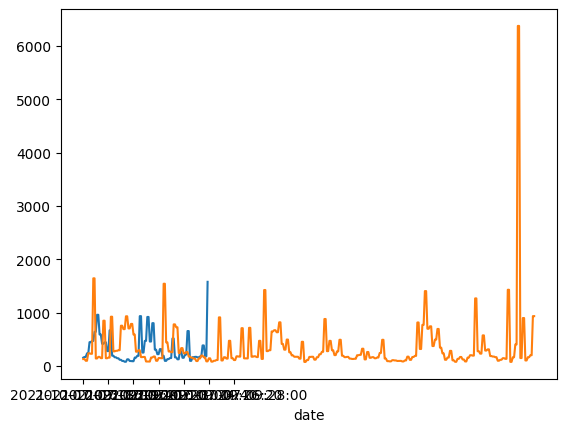

In [8]:
# SHOW AN EXAMPLE OF TRAIN AND TEST

y_train = pd.read_csv('Dataset/Train/train_360_window.csv',index_col="date")
y_test = pd.read_csv('Dataset/Test/test_100_Train_360_test_window.csv',index_col="date")
y_target_train = y_train['p95 deploy/frontend']
y_target_test = y_test['p95 deploy/frontend']
y_target_test.groupby('date').mean().plot()
y_target_train.groupby('date').mean().plot()


# Models

## LSTM

### Tensor Flow

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense,LSTM,Activation,Dropout
import keras.callbacks
df = pd.read_csv('Dataset/Train/train_360_window.csv',index_col="date")
train_x=df.iloc[:,:-1].values
train_y=df.iloc[:,-1].values

In [10]:
train_x.shape[1]

59

In [11]:

# design network
model_1 = Sequential()
model_1.add(LSTM(128,return_sequences=True, input_shape=(train_x.shape[1])))
model_1.add(LSTM(12))
model_1.add(Dropout(0.3))
model_1.add(Dense(1))
model_1.compile(loss='mae', optimizer='adam', metrics=['mse']) #changed from ['mse']

callback = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]  

model_1.summary()

TypeError: 'int' object is not iterable

In [ ]:
# fit network
history = model_1.fit(train_x, train_y, epochs=50, batch_size=10, verbose=2, shuffle=False,callbacks=[callback])

# plot history
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

Epoch 1/50


2023-04-27 15:13:36.457338: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/keras/engine/training.py", line 1023, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_3" is incompatible with the layer: expected shape=(None, 360, 59), found shape=(10, 59)


### PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

In [28]:
# define dataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_size, output_size, target_col):
        self.data = data
        self.input_size = input_size
        self.output_size = output_size
        self.target_col = target_col

    def __len__(self):
        return len(self.data) - self.input_size - self.output_size + 1

    def __getitem__(self, idx):
        input_seq = self.data[idx:idx+self.input_size, :]
        output_seq = self.data[idx+self.input_size:idx+self.input_size+self.output_size, self.target_col]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(output_seq, dtype=torch.float32)

In [70]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [59]:
# read data and set hyperparameters
train_df = pd.read_csv('Dataset/Train/Train_norm_full.csv', index_col=0)
input_size = 100
output_size = 20
hidden_size = 64
num_epochs = 20
learning_rate = 0.1
target_col = 59  # set the index of the target featuree)

/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 20, 1])) that is different to the input size (torch.Size([1, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE on test data: 0.005657 Input:  20 Output:  20


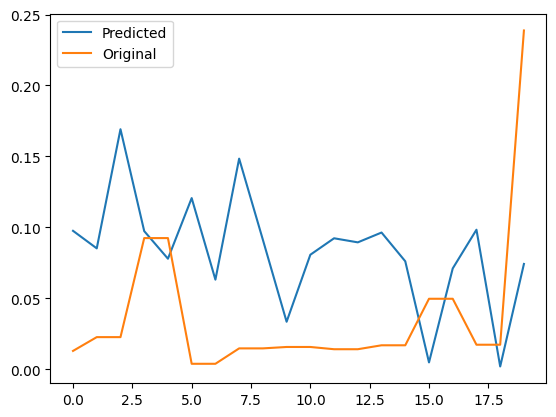

MSE on test data: 0.002373 Input:  60 Output:  20


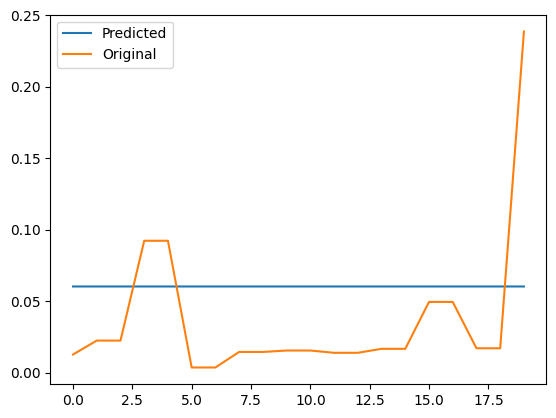

MSE on test data: 0.004796 Input:  120 Output:  20


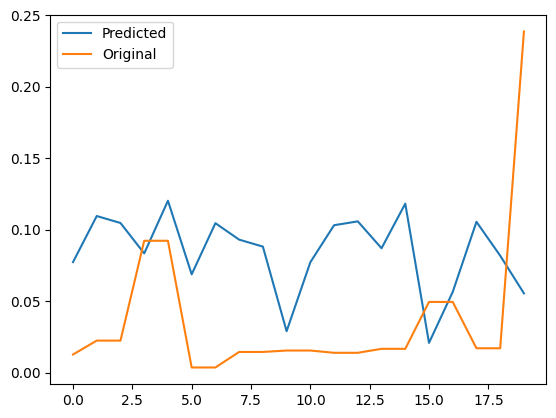

In [80]:
##LOOP
input_sizes = [20,60,120,360,720]
output_sizes = [20,50,100,400,1000]
for output_size in output_sizes:
    for input_size in input_sizes:
        # initialize dataset and data loader
        dataset = TimeSeriesDataset(train_df.values, input_size, output_size, target_col)
        data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

        # initialize model and optimizer
        model = LSTM(train_df.shape[1], hidden_size, output_size)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            epoch_mse = 0.0
            for input_seq, output_seq in data_loader:
                optimizer.zero_grad()
                model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
                output = model(input_seq)
                loss = criterion(output, output_seq.unsqueeze(-1))
                mse_loss = nn.MSELoss()(output, output_seq.unsqueeze(-1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                epoch_mse += mse_loss.item()
            #print('Epoch {}/{} Loss: {} MSE: {}'.format(epoch+1, num_epochs, epoch_loss/len(data_loader), epoch_mse/len(data_loader)))
        
        # Test
        # Initialize dataset and data loader
        test_dataset = TimeSeriesDataset(test_df.values, input_size, output_size,target_col=59)
        test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        # Set model to evaluation mode
        model.eval()

        # Calculate MSE on test data
        mse = 0
        with torch.no_grad():
            for input_seq, output_seq in test_data_loader:
                model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
                output = model(input_seq)
                mse += criterion(output, output_seq.unsqueeze(-1)).item()

        mse /= len(test_data_loader)
        print('MSE on test data: {:.6f}'.format(mse), "Input: ",input_size, "Output: ",output_size)
        #Evaluate
        # plot original vs predicted values
        plt.plot(output.squeeze().detach().numpy(), label='Predicted')
        plt.plot(output_seq.squeeze().detach().numpy(), label='Original')
        plt.legend()
        plt.show()
        #Save on file

        


In [71]:
# initialize dataset and data loader
dataset = TimeSeriesDataset(train_df.values, input_size, output_size, target_col)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# initialize model and optimizer
model = LSTM(train_df.shape[1], hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [73]:
# train model
for epoch in range(num_epochs):
    epoch_loss = 0.0
    epoch_mse = 0.0
    for input_seq, output_seq in data_loader:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        output = model(input_seq)
        loss = criterion(output, output_seq.unsqueeze(-1))
        mse_loss = nn.MSELoss()(output, output_seq.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_mse += mse_loss.item()
    print('Epoch {}/{} Loss: {} MSE: {}'.format(epoch+1, num_epochs, epoch_loss/len(data_loader), epoch_mse/len(data_loader)))

/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 20, 1])) that is different to the input size (torch.Size([1, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[ 0.0049,  0.0287,  0.0323,  0.0322,  0.0295,  0.0329,  0.0246,  0.0215,
          0.0322,  0.0411,  0.0222,  0.0329,  0.0319,  0.0365,  0.0120,  0.0330,
          0.0309, -0.0242,  0.0310,  0.0330]], grad_fn=<AddmmBackward0>)
Epoch 1/20 Loss: 0.003013942683778197 MSE: 0.003013942683778197
tensor([[-7.8042e-02,  3.5050e-02,  5.1410e-02,  4.7193e-02,  1.4355e-01,
          1.1833e-01, -1.0638e-02, -6.4091e-03,  1.3425e-02, -1.0277e-02,
          4.7382e-02,  2.3141e-02, -1.2855e-02, -1.6806e-02,  4.0042e-03,
          1.2869e-02, -1.3244e-02,  1.0185e-01, -5.2452e-06,  7.5916e-03]],
       grad_fn=<AddmmBackward0>)
Epoch 2/20 Loss: 0.008183376689821682 MSE: 0.008183376689821682


KeyboardInterrupt: 

#### Test

In [76]:
# Load test data
test_df = pd.read_csv('Dataset/Test/Test_norm_full.csv', index_col=0)

# Initialize dataset and data loader
test_dataset = TimeSeriesDataset(test_df.values, input_size, output_size,target_col=59)
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Set model to evaluation mode
model.eval()

# Calculate MSE on test data
mse = 0
with torch.no_grad():
    for input_seq, output_seq in test_data_loader:
        model.hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        output = model(input_seq)
        mse += criterion(output, output_seq.unsqueeze(-1)).item()

mse /= len(test_data_loader)
print('MSE on test data: {:.6f}'.format(mse))

/opt/homebrew/Caskroom/miniforge/base/envs/GIG/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 20, 1])) that is different to the input size (torch.Size([1, 20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE on test data: 0.004128


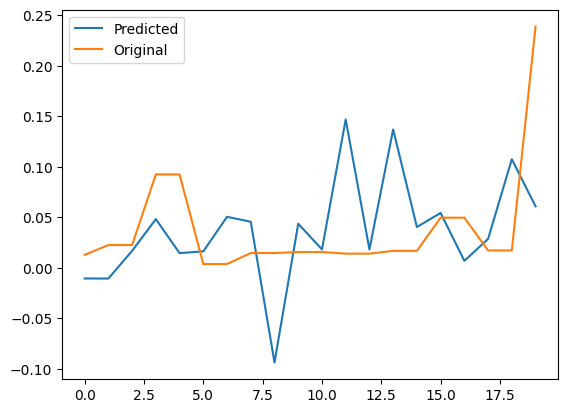

In [77]:
import matplotlib.pyplot as plt

# plot original vs predicted values
plt.plot(output.squeeze().detach().numpy(), label='Predicted')
plt.plot(output_seq.squeeze().detach().numpy(), label='Original')
plt.legend()
plt.show()

## Informer

In [ ]:
import sys
import os
sys.path.append('/Users/emlanza/Library/CloudStorage/OneDrive-UniversidadAustral/Facultad/Maestria Data Science AUSTRAL/Tesis/Transformers-for-latency-prediction/Informer/Informer2020')

In [ ]:
from data.data_loader import Dataset_Custom
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
from torch.utils.data import DataLoader
import pandas as pd
import os

In [ ]:
concat[start token series(label_len), zero padding series(pred_len)

In [ ]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'train_norm' # data
args.root_path = './Dataset/Train/' # root path of data file
args.data_path = 'train_norm.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'p95 deploy/frontend' # target feature in S or MS task
args.freq = '5s' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 60 # encoder input size
args.dec_in = 60 # decoder input size
args.c_out = 1 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

#args.use_gpu = True if torch.cuda.is_available() else False
#args.gpu = 0

#args.use_multi_gpu = False
#args.devices = '0,1,2,3'

In [ ]:
df1 = pd.read_csv(os.path.join(args.root_path, args.data_path))
df1

,date,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,p95 deploy/frontend
0,2021-10-07 09:18:00,1.000000,0.157143,0.101040,0.044530,0.095238,0.070410,2.220446e-16,0.071429,0.033017,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,1.00000,131.000000
1,2021-10-07 09:18:05,0.750000,0.400000,0.041605,0.044530,0.142857,0.070410,2.220446e-16,0.071429,0.047634,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,1.00000,131.000000
2,2021-10-07 09:18:10,0.750000,0.400000,0.041605,0.043667,0.142857,0.063853,2.220446e-16,0.285714,0.047634,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,99.027778
3,2021-10-07 09:18:15,0.635417,0.254839,0.108470,0.043667,0.228571,0.063853,2.220446e-16,0.285714,0.021948,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,99.027778
4,2021-10-07 09:18:20,0.635417,0.254839,0.108470,0.035852,0.228571,0.063973,2.220446e-16,0.214286,0.021948,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,240.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724,2021-10-07 11:41:40,0.000000,0.331507,0.041605,0.060057,0.285714,0.169192,1.110223e-16,0.071429,0.043823,...,0.49985,0.49995,0.49995,0.454000,0.0,0.388461,0.49995,0.0,0.49995,232.272727
1725,2021-10-07 11:41:45,0.001913,0.400000,0.041605,0.060057,0.571429,0.169192,1.110223e-16,0.071429,0.216677,...,0.49985,0.49995,0.49995,0.544909,0.0,0.610683,0.49995,0.0,0.49995,232.272727
1726,2021-10-07 11:41:50,0.001913,0.400000,0.041605,0.091994,0.571429,0.193548,1.110223e-16,0.228571,0.216677,...,0.49985,0.49995,0.49995,0.544909,0.0,0.610683,0.49995,0.0,0.49995,302.727273
1727,2021-10-07 11:41:55,0.001420,0.367480,0.108470,0.091994,0.214286,0.193548,2.220446e-16,0.228571,0.193789,...,0.49985,0.49995,0.49995,0.499450,0.0,0.499550,0.49995,0.0,0.49995,302.727273


In [ ]:
Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [ ]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'train_norm', 'root_path': './Dataset/Train/', 'data_path': 'train_norm.csv', 'features': 'M', 'target': 'p95 deploy/frontend', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 60, 'dec_in': 60, 'c_out': 60, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp'}


In [ ]:
data_parser = {
    'ETTh1':{'data':'train_norm.csv','T':'p95 deploy/frontend','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}

if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [ ]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [ ]:
Exp = Exp_Informer

In [ ]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

Use CPU
>>>>>>>start training : informer_train_norm_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 1091
val 151
test 322
Epoch: 1 cost time: 198.4474537372589
Epoch: 1, Steps: 34 | Train Loss: nan Vali Loss: nan Test Loss: nan
Validation loss decreased (inf --> nan).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 197.35375213623047
Epoch: 2, Steps: 34 | Train Loss: nan Vali Loss: nan Test Loss: nan
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 180.4554922580719
Epoch: 3, Steps: 34 | Train Loss: nan Vali Loss: nan Test Loss: nan
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 176.95927119255066
Epoch: 4, Steps: 34 | Train Loss: nan Vali Loss: nan Test Loss: nan
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5 cost t

### Prediction


In [ ]:
import os

# set saved model path
setting = 'informer_train_norm_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')